# Jazz Datasets
This program is an investigation into the [Weimar jazz database](https://jazzomat.hfm-weimar.de/dbformat/dboverview.html) and the [JazzSet](https://old.reddit.com/r/datasets/comments/1b73vz3/jazzset_large_audio_dataset_with_instrumentation/) to see if a large data set of transcribed solo playing can be found. 

The Weimar Jazz Database contains 456 transcribed jazz solos. The database is encoded using a library called [MeloSpyLib](https://jazzomat.hfm-weimar.de/melospy/melospy.html), where melodies as stored as "Melodical objects". The fundamental objects are `Rhythms`, which are sequences of `RhythmEvents`. Rhythm events are defined as triplets (`onset, duration, value`), where onset and duration are measured in seconds, and values can be any object. 

The JazzSet contains 40,329 recordings with over 2200 hours of audio. 

## Loading the Weimar Jazz Database
The database is encoded in sqlite in a .db file. Loading this database is simple using the sqlite3 library. This will allow us to run SQL queries later. 

In [1]:
import sqlite3
con = sqlite3.connect("file:wjazzd.db?mode=rw")
cur = con.cursor()

## Loading the JazzSet Database
This database contains a .pkl file containing information for all tracks in cards, with one card for each track. We access this data using provided functions imported from JazzSetDS.py. We also make some tables in SQL from the data for ease of manipulation and comparison to the Weimar Jazz Database. 

In [2]:
from JazzSetDS import *
cards = Load("JazzSet.0.9.pkl",pad=False)

cur.execute("DROP TABLE IF EXISTS card_performers")
cur.execute("DROP TABLE IF EXISTS card_performances")
cur.execute("DROP TABLE IF EXISTS card_tracks")
cur.execute("CREATE TABLE card_performers(id, name)")
cur.execute("CREATE TABLE card_tracks(id, title, year)")
cur.execute("CREATE TABLE card_performances(track_id, performer_id)")
performers = []

for card in cards:
    if card:
        cur.execute("INSERT INTO card_tracks VALUES(:id, :title, :year)",
                    {'id': card['#'], 'title': card['TITLE'], 'year': card['DATE']['YEAR']})
        for performer in list(card['PERSONNEL']['PEOPLE'].keys()):
            if performer not in performers:
                performers.append(performer)
                cur.execute("INSERT INTO card_performers VALUES(:id, :name)", {'id': len(performers), 'name': performer})
            
            cur.execute("INSERT INTO card_performances VALUES(:track_id, :performer_id)",
                        {'track_id': card['#'], 'performer_id': performers.index(performer)})

## Comparing the time-ranges of the databases
Having loaded both databases, we can look at a few different aspects of the data. First, we look at when the solos were performed. 

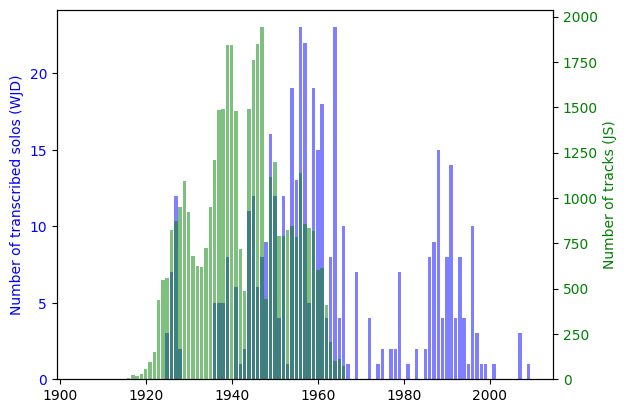

In [3]:
# Extracting the year from the inconsistently written date information in the Weimar jazz database
import re
res = cur.execute("SELECT trackid,  recordingdate\
        FROM track_info")
allTracks = res.fetchall()
trackData = []
years = []
for track in allTracks:
    year = re.findall(r"\b\d{4}\b", track[1])[0]    
    years.append(int(year))
    trackData.append({"trackid": track[0], "year": int(year)})

cur.execute("DROP TABLE IF EXISTS track_years")
cur.execute("CREATE TABLE track_years(trackid,year)")
cur.executemany("INSERT INTO track_years VALUES(:trackid, :year)", trackData)
cur.execute("DROP TABLE  IF EXISTS track_info_dated")
cur.execute("CREATE TABLE track_info_dated AS SELECT track_info.*, track_years.year\
             FROM track_info  \
             LEFT JOIN track_years  \
                 ON track_info.trackid = track_years.trackid")

# Querying the WJD for the number of solos per year
res = cur.execute("SELECT tid.year, COUNT(*) AS num_solos\
                   FROM solo_info AS si\
                   LEFT JOIN track_info_dated AS tid \
                   ON tid.trackid = si.trackid \
                   GROUP BY tid.year \
                   ORDER BY tid.year ASC")
year_data_wjd = res.fetchall()

# Querying the JazzSet for the number of solos per year
res = cur.execute("SELECT year, COUNT(*) AS num_solos\
                   FROM card_tracks\
                   GROUP BY year \
                   ORDER BY year ASC")
year_data_js = res.fetchall()

# Formatting the data for plotting
import matplotlib.pyplot as plt
y_labels_wjd = []
entries_wjd = []
for year_data in year_data_wjd:
    y_labels_wjd.append(year_data[0])
    entries_wjd.append(year_data[1])
y_labels_js = []
entries_js = []
for year_data in year_data_js:    
    y_labels_js.append(year_data[0])
    entries_js.append(year_data[1])

# plotting the data
fig, ax1 = plt.subplots()

# plotting WJD data
ax1.bar(y_labels_wjd,entries_wjd, color='blue',alpha=0.5, label='Data 1')
ax1.set_ylabel('Number of transcribed solos (WJD)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# plotting JS data
ax2 = ax1.twinx()
ax2.bar(y_labels_js, entries_js, color='green', alpha=0.5, label='Data 2')
ax2.set_ylabel('Number of tracks (JS)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

We see that there is some overlap between the solos, let's see if there are any performances in common. 

# Finding common tracks 
Finding tracks that appear in both databases becomes reasonably easy now that appropriate tables are set up. We look for tracks that have same title, the same performer, and were performed in roughly the same year. 

In [6]:
res = cur.execute("SELECT ct.title, si.performer,  tid.year\
                        FROM solo_info si\
                        LEFT JOIN track_info_dated tid \
                            ON si.trackid = tid.trackid \
                        LEFT JOIN composition_info ci \
                            ON si.compid = ci.compid \
                        LEFT JOIN card_tracks as ct \
                            ON LOWER(ct.title) = LOWER(si.title) \
                                OR LOWER(ct.title) = LOWER(ci.title) \
                        LEFT JOIN card_performances as cp\
                            ON cp.track_id = ct.id\
                        LEFT JOIN card_performers as p\
                            ON p.id = cp.performer_id\
                        WHERE LOWER(si.performer) = LOWER(p.name) \
                        AND  ABS(ct.year-tid.year) < 3")
results = res.fetchall()
print("There are " + str(len(results)) + " solos from the WJD included in the JS dataset")
print(results[:][:])

There are 16 solos from the WJD included in the JS dataset
[('Whispering', 'Benny Goodman', 1936), ('Body And Soul', 'Chu Berry', 1938), ('Body And Soul', 'Chu Berry', 1938), ('Got No Blues', 'Johnny Dodds', 1927), ('Heebie Jeebies', 'Johnny Dodds', 1926), ('Hotter Than That', 'Johnny Dodds', 1927), ('Muskrat Ramble', 'Johnny Dodds', 1926), ('My Heart', 'Johnny Dodds', 1925), ('Once In A While', 'Johnny Dodds', 1927), ("Dickie's Dream", 'Lester Young', 1939), ('Lester Leaps In', 'Lester Young', 1939), ('Six Cats And A Prince', 'Lester Young', 1944), ("Don't Get Around Much Anymore", 'Milt Jackson', 1952), ('Work Song', 'Nat Adderley', 1960), ('Work Song', 'Nat Adderley', 1960), ('Body And Soul', 'Sonny Stitt', 1948)]


Therefore we find that there are only very few tracks in common, and so this is not a particularly useful collection of datasets for us to use. 